In [2]:
###############################################################################
############### Term Project - Dog & Cat Classification #######################
######################### Author - Siyuan Liu #################################
########################### March 2022 ########################################

In [3]:
#https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

In [4]:
# Helper libraries
import os 
import numpy as np
import tensorflow as tf
import time
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import re # regular expressions
import scipy
import os # Operation System
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
import tensorflow as tf
from datetime import datetime
import cv2
import seaborn as sns


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
#from plot_keras_history import plot_history

In [5]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [6]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)


This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [7]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Load the data

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import zipfile
train_file = "/content/gdrive/MyDrive/458_AI/A4/train.zip"
with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

test_file = "/content/gdrive/MyDrive/458_AI/A4/test.zip"
with zipfile.ZipFile(test_file, 'r') as z:
    z.extractall()

z.close()

In [11]:
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
train_img_names = os.listdir(train_dir)

test_dir = os.path.join(base_dir, 'test') 
test_img_names = os.listdir(test_dir)

In [12]:
train_img_names[:10]

['cat.10613.jpg',
 'cat.7065.jpg',
 'dog.4677.jpg',
 'cat.2305.jpg',
 'cat.11144.jpg',
 'cat.4830.jpg',
 'dog.8646.jpg',
 'dog.4178.jpg',
 'dog.496.jpg',
 'dog.11782.jpg']

In [13]:
test_img_names[:10]

['11390.jpg',
 '4977.jpg',
 '7427.jpg',
 '5513.jpg',
 '3415.jpg',
 '12276.jpg',
 '4666.jpg',
 '3015.jpg',
 '4275.jpg',
 '11417.jpg']

In [14]:
print('total train images :', len(train_img_names ))
print('total test images :', len(test_img_names ))

total train images : 25000
total test images : 12500


In [15]:
# Sorting of file names facilitated by
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)    

train_ls = directory_list(train_dir)
len(train_ls)
test_ls = directory_list(test_dir)
len(test_ls)

12500

In [16]:
train_ls[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg']

In [17]:
#split the file name and extract label data
labels = []
for image in train_ls:
    label = image.split(".")[0]
    if label == "dog":
        labels.append("dog")
    else:
        labels.append("cat")
df_train = pd.DataFrame({"Image":train_img_names, "label": labels})

In [18]:
df_train.head()

,Image,label
0,cat.10613.jpg,cat
1,cat.7065.jpg,cat
2,dog.4677.jpg,cat
3,cat.2305.jpg,cat
4,cat.11144.jpg,cat


#EDA

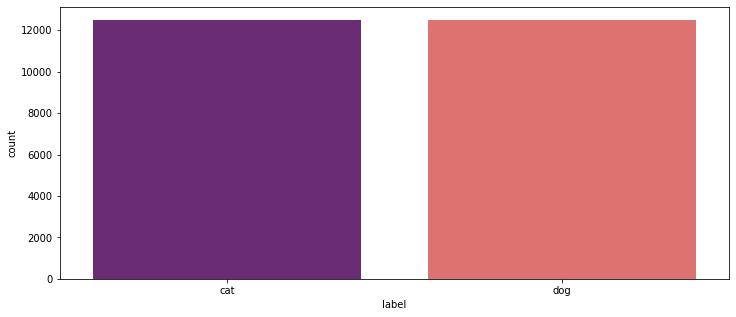

In [19]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_train, x="label",palette="magma") 

In [20]:
print(df_train['label'].value_counts())

cat    12500
dog    12500
Name: label, dtype: int64


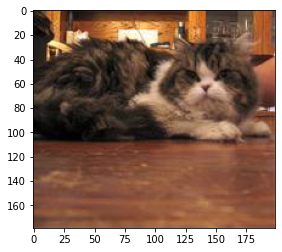

In [21]:
import random
ran_spl = random.choice(train_img_names)
plt.imshow(plt.imread(("/content/train/"+ran_spl)))

In [22]:
#image processing functions
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

In [23]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [24]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [25]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [26]:
import errno
outdir = '/content/cats_dogs_arrays'
try:
    os.makedirs(outdir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [27]:
# Create Numpy Image Arrays
#----------------------------------------------------------------------
print('\nProcessing image files to 64x64 color or grayscale arrays')
# Create train_128_128_3, test_128_128_3 and numpy array for 3000/ 12500 images in color
# train_128_128_3 = np.zeros((25000, 128, 128, 3))  
# for ifile in range(len(train_ls)):
#     image_file_path = os.path.join(train_dir, train_ls[ifile])
#     image = parse_color_and_resize(image_file_path, size = (128, 128))
#     train_128_128_3[ifile,:,:,:] = image    

# test_128_128_3 = np.zeros((12500, 128, 128, 3))  
# for ifile in range(len(test_ls)):
#     image_file_path = os.path.join(test_dir, test_ls[ifile])
#     image = parse_color_and_resize(image_file_path, size = (128, 128))
#     test_128_128_3[ifile,:,:,:] = image    
    
train_64_64_1 = np.zeros((25000, 64, 64, 1))  
for ifile in range(len(train_ls)):
    image_file_path = os.path.join(train_dir, train_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    train_64_64_1[ifile,:,:,0] = image
    
test_64_64_1 = np.zeros((12500, 64,64, 1))  
for ifile in range(len(test_ls)):
    image_file_path = os.path.join(test_dir, test_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    test_64_64_1[ifile,:,:,0] = image
    
# Save numpy array objects for analysis       
# np.save(os.path.join(outdir, 'train_128_128_3.npy'), train_128_128_3)
np.save(os.path.join(outdir, 'train_64_64_1.npy'), train_64_64_1)
# np.save(os.path.join(outdir, 'test_128_128_3.npy'), test_128_128_3)
np.save(os.path.join(outdir, 'test_64_64_1.npy'), test_64_64_1)



Processing image files to 64x64 color or grayscale arrays


In [28]:
# Global Functions & variables
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
random_seed=9999
from tensorflow.python.framework import ops


#Reset Graphs for Tensorboard
def reset_graph(seed= random_seed):
    ops.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    
#Save images to working directory
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(work_dir, "images", chp_id, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    

#Randomly Sort Batches
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    
#Check distribtion of test , valid and train
def dist_plot(var1, var2, var3):
    tmp_plt=sns.countplot(var1, palette="Blues").set_title(var2)
    tmp_fig = tmp_plt.get_figure()
    tmp_fig.savefig(var3 + ".png", 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)
    return(tmp_plt)

Instructions for updating:
non-resource variables are not supported in the long term


#Data Preprocessing & Preparation

using grey colored images for training

In [29]:
train_64_64_1 = np.load(base_dir + '/cats_dogs_arrays/train_64_64_1.npy')
test_64_64_1 = np.load(base_dir + '/cats_dogs_arrays/test_64_64_1.npy')

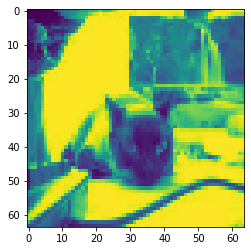

In [30]:
plt.imshow(train_64_64_1[5,:,:,0])

In [31]:
#normalize the data

X_train = train_64_64_1
X_test = test_64_64_1

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#remove standardization scaling as it is good to make the input values between 0 and 1

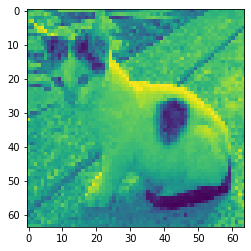

In [32]:
plt.imshow(X_train[3,:,:,0])

In [33]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
df_train['label_n'] = np.where(df_train['label']=='cat', 0, 1)

y_train = df_train['label_n'].to_numpy()
y_train


array([0, 0, 0, ..., 1, 1, 1])

In [34]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(X_train
                                                                              ,y_train
                                                                              ,test_size=.2
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [35]:
print(np.unique(y_train_split, return_counts=True))
print(np.unique(y_valid_split, return_counts=True))

(array([0, 1]), array([ 9985, 10015]))
(array([0, 1]), array([2515, 2485]))


In [36]:
print(x_train_split.shape)
print(x_valid_split.shape)
print(X_test.shape)

(20000, 64, 64, 1)
(5000, 64, 64, 1)
(12500, 64, 64, 1)


In [37]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [38]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [36]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val
  f1_val = f1_score(y_val, pred_val, average = 'macro')
  result_dic['f1_val'] = f1_val
  recall_val = recall_score(y_val, pred_val, average = 'macro')
  result_dic['recall_val'] = recall_val
  precision_val = precision_score(y_val, pred_val, average = 'macro')
  result_dic['precision_val'] = precision_val

  #there is no test label dataset, since it is for competition

  return result_dic

#Experiment 9 - CNN with 5 layers (with regularization)


1. 5 Conv Layer + Pooling Layers
- use bigger kernel_size in the 1st conv layer; use smaller kernel_size in the following conv layers
- use "padding = SAME" for all conv layers
2. with L2 regularization
3. With Dropout & Batch_Normalization layer
- adding dropout (0.1) after conv layers
- adding dropout (0.5) after dense layers

In [ ]:
model_9 = models.Sequential()
model_9.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding = 'same', activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_9.add(layers.MaxPool2D((2, 2),strides=2))
model_9.add(layers.Dropout(0.1))
model_9.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_9.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_9.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_9.add(layers.Dropout(0.1))
model_9.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_9.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_9.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_9.add(layers.Flatten())
model_9.add(layers.BatchNormalization())
model_9.add(layers.Dense(units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_9.add(layers.Dropout(0.5))
model_9.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
model_9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [50]:

start_time = time.time()

history_9 = model_9.fit(x_train_split
                    ,y_train_split
                    ,epochs=30
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 646s 32ms/sample - loss: 0.7448 - acc: 0.6296 - val_loss: 0.7272 - val_acc: 0.5232
Epoch 2/30
20000/20000 [==============================] - 629s 31ms/sample - loss: 0.6028 - acc: 0.7115 - val_loss: 0.6900 - val_acc: 0.6022
Epoch 3/30
20000/20000 [==============================] - 631s 32ms/sample - loss: 0.5367 - acc: 0.7580 - val_loss: 0.9105 - val_acc: 0.6466
Epoch 4/30
20000/20000 [==============================] - 627s 31ms/sample - loss: 0.4969 - acc: 0.7764 - val_loss: 2.5891 - val_acc: 0.5098
Epoch 5/30
20000/20000 [==============================] - 652s 33ms/sample - loss: 0.4790 - acc: 0.7979 - val_loss: 0.7797 - val_acc: 0.6796
Epoch 6/30
20000/20000 [==============================] - 618s 31ms/sample - loss: 0.4482 - acc: 0.8124 - val_loss: 0.6644 - val_acc: 0.7248
Epoch 7/30
20000/20000 [==============================] - 619s 31ms/sample - loss: 0.4443 - acc: 0.8271 -

In [51]:
train_time = end_time - start_time

In [52]:
model_9_score = score_track(model_9, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [53]:
model_9_score

{'accuracy_train': 0.92045,
 'accuracy_valid': 0.849,
 'f1_val': 0.8484580800325194,
 'precision_val': 0.8549766849974412,
 'recall_val': 0.8493893780176086}

In [54]:
model_9_score['train_time'] = train_time

In [56]:
preds_9 = model_9.predict(X_test)
print('shape of preds: ', preds_9.shape)

shape of preds:  (12500, 2)


In [57]:
history_dict = history_9.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [58]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
12,0.335,0.877,0.548,0.806
13,0.335,0.881,0.463,0.840
14,0.343,0.889,0.462,0.849
15,0.318,0.897,0.404,0.856
16,0.317,0.900,0.449,0.849


In [59]:
losses = history_9.history['loss']
accs = history_9.history['acc']
val_losses = history_9.history['val_loss']
val_accs = history_9.history['val_acc']
epochs = len(losses)

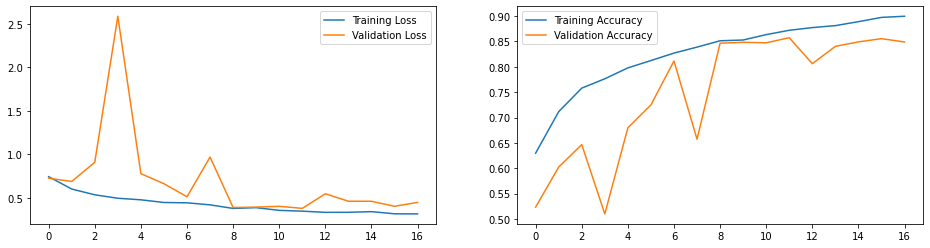

In [60]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [61]:
#confusion matrix generation

pred9_val= model_9.predict(x_valid_split)
pred9_val=np.argmax(pred9_val, axis=1)

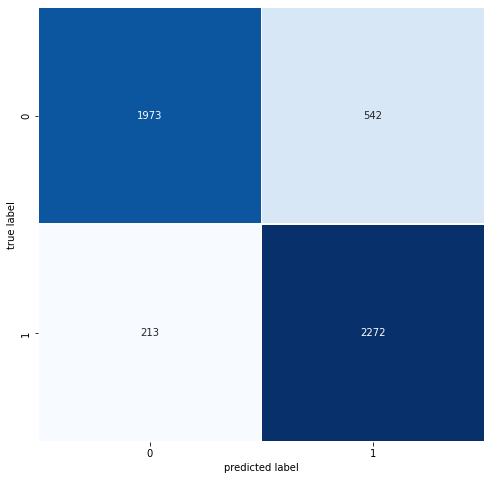

In [62]:
plot_confusion_matrix(y_valid_split,pred9_val)

In [ ]:
model_9_score

###Extract Features output from filter and visualize them in a grid as images.

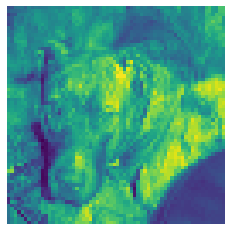

In [92]:
import random

i = random.randint(0, len(train_64_64_1))

img_tensor = np.reshape(train_64_64_1[i], (1, 64, 64, 1))

plt.imshow(train_64_64_1[i,:,:,0])
plt.axis('off')
plt.show()

In [93]:
img_tensor.shape

(1, 64, 64, 1)

In [94]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_9.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_9.input, outputs=layer_outputs)

In [95]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [96]:
layer_names = []
for layer in model_9.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_5',
 'max_pooling2d_3',
 'dropout_3',
 'conv2d_6',
 'conv2d_7',
 'max_pooling2d_4',
 'dropout_4',
 'conv2d_8',
 'conv2d_9',
 'max_pooling2d_5',
 'flatten_1',
 'batch_normalization_1',
 'dense_2',
 'dropout_5',
 'dense_3']

In [97]:
activations[0].shape

(1, 64, 64, 64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


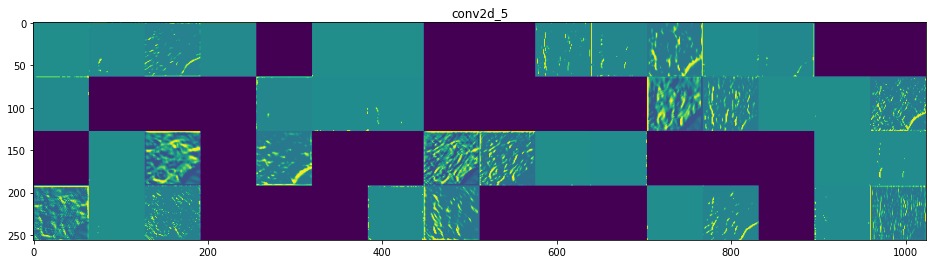

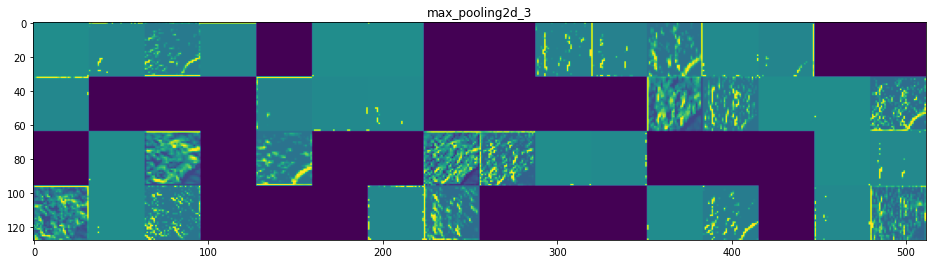

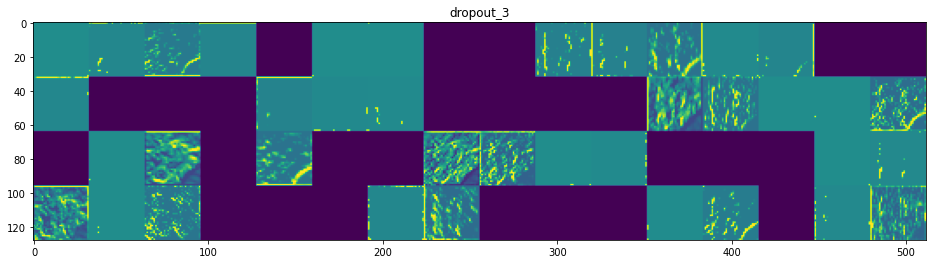

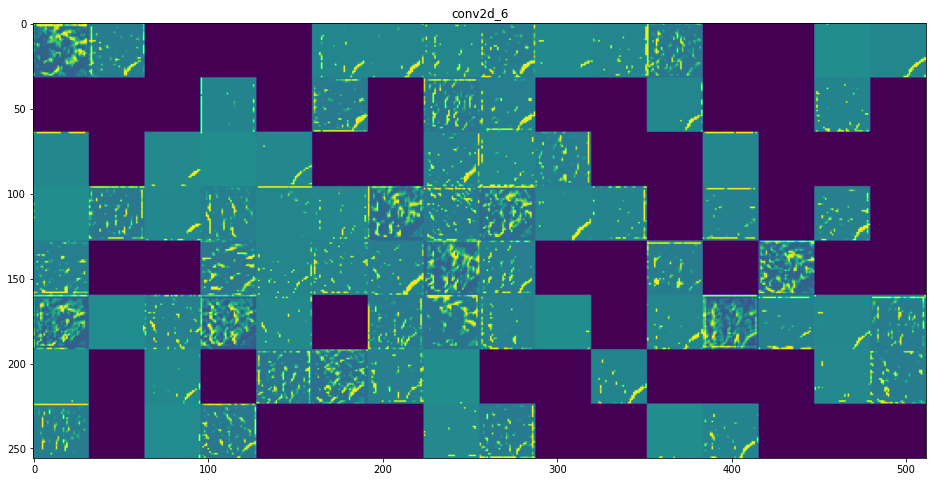

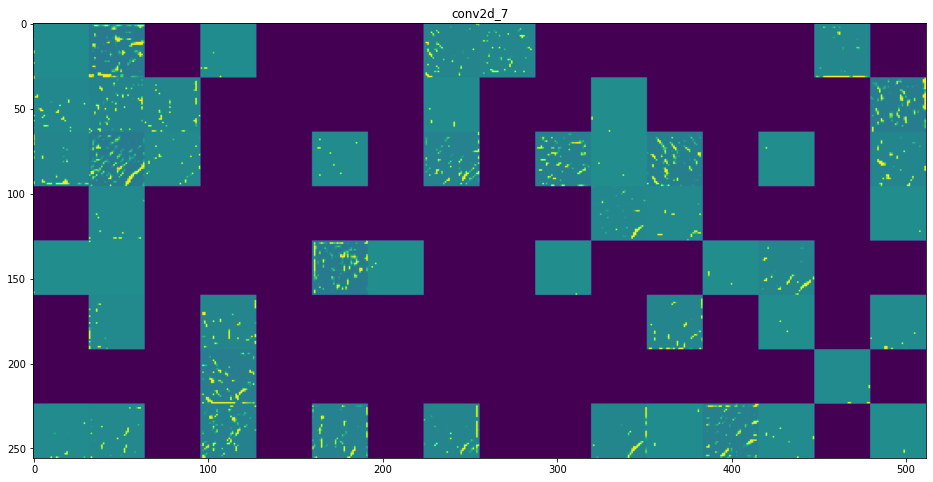

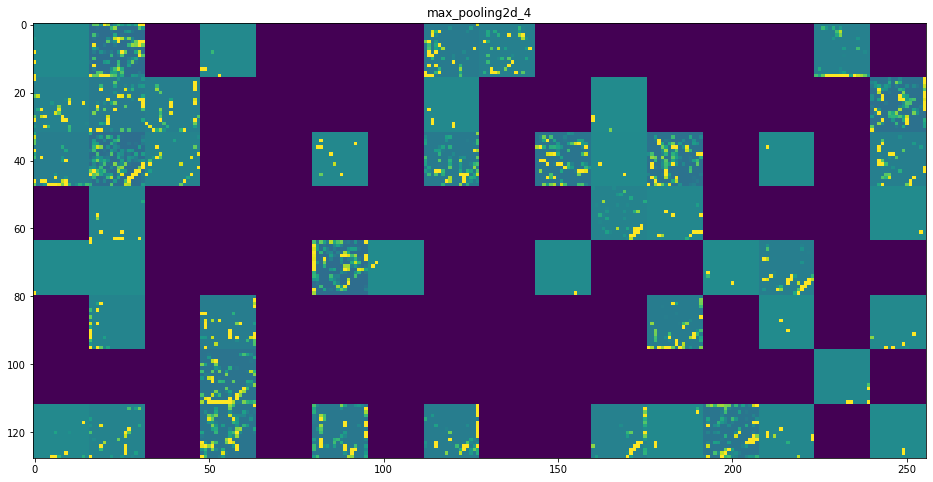

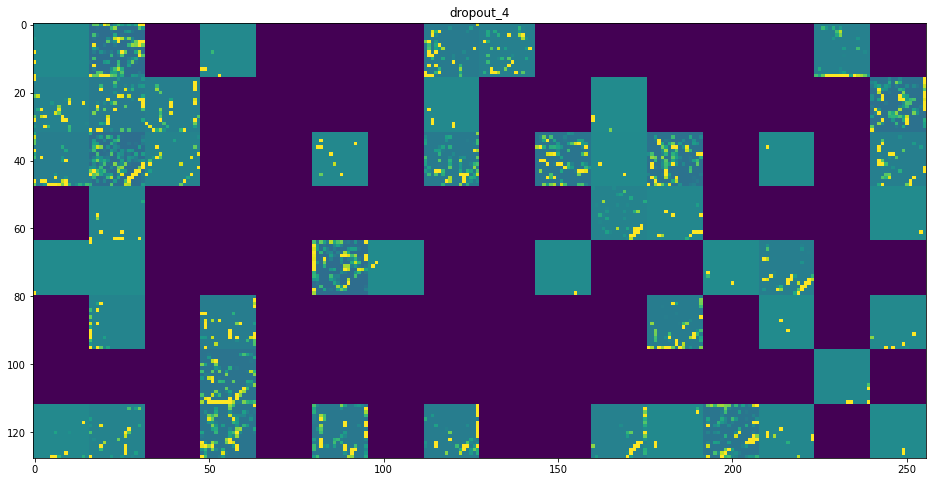

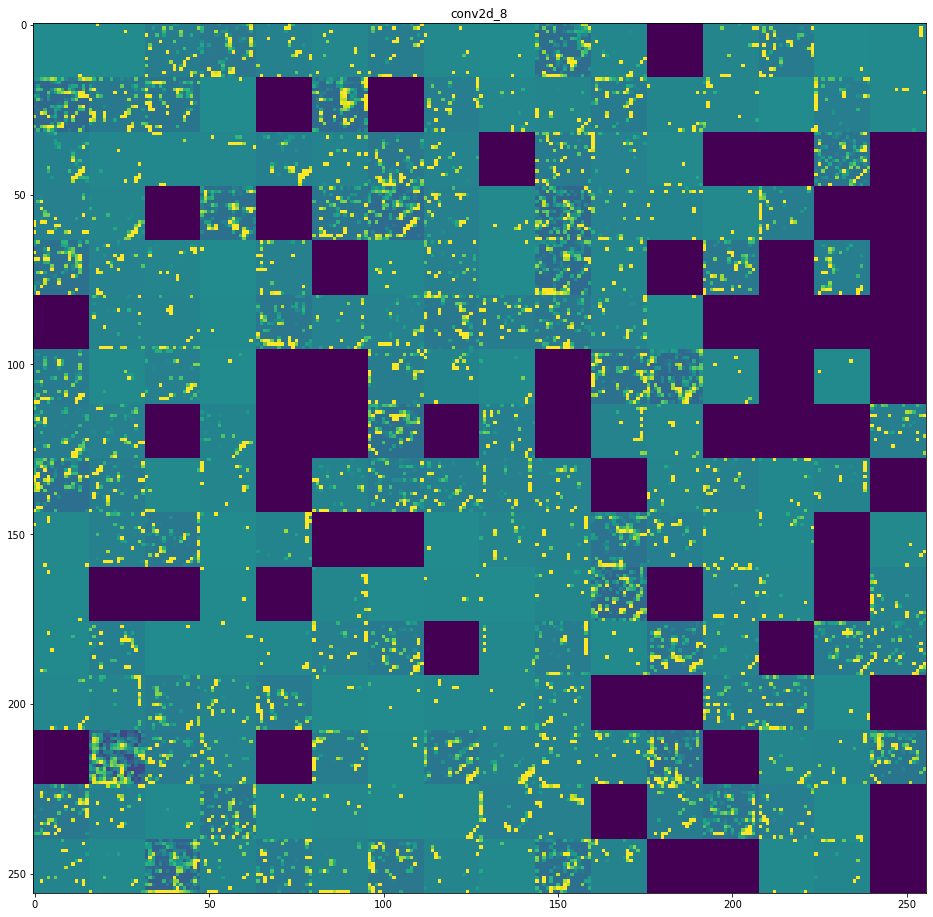

In [99]:
layer_names = []
for layer in model_9.layers[:10]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map -> which is number of filters
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features), which is width and height
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();



#Experiment 10 - ResNet + Data Augmentation
- use ImageDataGenerator to augment the date
- load ResNet 50 as training model

In [100]:
#use ImageDataGenerator for preprocessing.  It helps in data augmentation and helps to get better accuracy by making data flow in batches. 
#Mini-Batch Gradient Descent uses a mini-batches of training example for each gradient calculation, 
#which makes convergence faster, and at the same time, utilise the speed up from vectorization.

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [20]:
# Create Numpy Image Arrays
#----------------------------------------------------------------------
# print('\nProcessing image files to 64x64 color or grayscale arrays')
# Create train_128_128_3, test_128_128_3 and numpy array for 3000/ 12500 images in color
train_64_64_3 = np.zeros((25000, 64, 64, 3))  
for ifile in range(len(train_ls)):
    image_file_path = os.path.join(train_dir, train_ls[ifile])
    image = parse_color_and_resize(image_file_path, size = (64, 64))
    train_64_64_3[ifile,:,:,:] = image    

test_64_64_3 = np.zeros((12500, 64, 64, 3))  
for ifile in range(len(test_ls)):
    image_file_path = os.path.join(test_dir, test_ls[ifile])
    image = parse_color_and_resize(image_file_path, size = (64, 64))
    test_64_64_3[ifile,:,:,:] = image    
    
# train_64_64_1 = np.zeros((25000, 64, 64, 1))  
# for ifile in range(len(train_ls)):
#     image_file_path = os.path.join(train_dir, train_ls[ifile])
#     image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
#     train_64_64_1[ifile,:,:,0] = image
    
# test_64_64_1 = np.zeros((12500, 64,64, 1))  
# for ifile in range(len(test_ls)):
#     image_file_path = os.path.join(test_dir, test_ls[ifile])
#     image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
#     test_64_64_1[ifile,:,:,0] = image
    
# Save numpy array objects for analysis       
# np.save(os.path.join(outdir, 'train_128_128_3.npy'), train_128_128_3)
np.save(os.path.join(outdir, 'train_64_64_3.npy'), train_64_64_3)
# np.save(os.path.join(outdir, 'test_128_128_3.npy'), test_128_128_3)
np.save(os.path.join(outdir, 'test_64_64_3.npy'), test_64_64_3)

In [21]:
train_64_64_3 = np.load(base_dir + '/cats_dogs_arrays/train_64_64_3.npy')
test_64_64_3 = np.load(base_dir + '/cats_dogs_arrays/test_64_64_3.npy')

In [22]:
#normalize the data

X_train_col = train_64_64_3
X_test_col = test_64_64_3

# X_train_col = X_train_col.astype('float32') / 255.0
# X_test_col = X_test_col.astype('float32') / 255.0

#remove standardization scaling as it is good to make the input values between 0 and 1

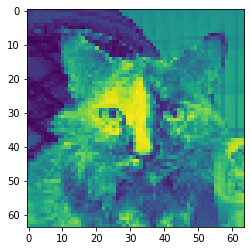

In [23]:
plt.imshow(X_train_col[10,:,:,0])

In [24]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
df_train['label_n'] = np.where(df_train['label']=='cat', 0, 1)

y_train = df_train['label_n'].to_numpy()
y_train


array([0, 0, 0, ..., 1, 1, 1])

In [25]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(X_train_col
                                                                              ,y_train
                                                                              ,test_size=.2
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [26]:
print(x_train_split.shape)
print(x_valid_split.shape)
print(X_test_col.shape)

(20000, 64, 64, 3)
(5000, 64, 64, 3)
(12500, 64, 64, 3)


In [27]:
train_datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, horizontal_flip = True, fill_mode = 'nearest', 
                                   width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function = preprocess_input)


train_gen = train_datagen.flow(x_train_split, y_train_split, batch_size = 64)

#we do not augment validation data.
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow(x_valid_split, y_valid_split, batch_size = 64)

In [28]:
x_train_split.shape

(20000, 64, 64, 3)

In [29]:
model_10 = Sequential()
model_10.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model_10.add(Dense(2, activation = 'softmax'))

model_10.layers[0].trainable = False 

Instructions for updating:
Colocations handled automatically by placer.
94781440/94765736 [==============================] - 1s 0us/step


In [30]:
model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [32]:
valid_gen

In [33]:

start_time = time.time()

history_10 = model_10.fit_generator(train_gen
                    ,epochs=30
                    ,validation_data=valid_gen
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Epoch 1/30
313/313 [==============================] - 254s 802ms/step - batch: 156.0000 - size: 63.8978 - loss: 0.7684 - acc: 0.7264 - val_loss: 1.4360 - val_acc: 0.7482
Epoch 2/30
313/313 [==============================] - 250s 798ms/step - batch: 156.0000 - size: 63.8978 - loss: 0.5739 - acc: 0.7671 - val_loss: 0.7412 - val_acc: 0.8102
Epoch 3/30
313/313 [==============================] - 248s 794ms/step - batch: 156.0000 - size: 63.8978 - loss: 0.5162 - acc: 0.7790 - val_loss: 0.9858 - val_acc: 0.7728
Epoch 4/30
313/313 [==============================] - 250s 801ms/step - batch: 156.0000 - size: 63.8978 - loss: 0.5071 - acc: 0.7847 - val_loss: 0.5883 - val_acc: 0.8424
Epoch 5/30
313/313 [==============================] - 258s 824ms/step - batch: 156.0000 - size: 63.8978 - loss: 0.5007 - acc: 0.7857 - val_loss: 0.7072 - val_acc: 0.8156
Epoch 6/30
313/313 [==============================] - 253s 809ms/step - batch: 156.0000 - size: 63.8978 - loss: 0.5017 - acc: 0.7849 - val_loss: 0.628

In [34]:
train_time = end_time - start_time

In [42]:
model_10_score = score_track(model_10, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [44]:
model_10_score

{'accuracy_train': 0.7822,
 'accuracy_valid': 0.7652,
 'f1_val': 0.7647193121434817,
 'precision_val': 0.767979522987946,
 'recall_val': 0.7654987579552863}

In [45]:
model_10_score['train_time'] = train_time

In [46]:
preds_10 = model_10.predict(X_test_col)
print('shape of preds: ', preds_10.shape)

shape of preds:  (12500, 2)


In [47]:
history_dict = history_10.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [48]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
6,0.505,0.786,0.624,0.843
7,0.513,0.787,1.626,0.709
8,0.517,0.782,0.668,0.836
9,0.514,0.782,0.955,0.782
10,0.504,0.784,0.639,0.827


In [49]:
losses = history_10.history['loss']
accs = history_10.history['acc']
val_losses = history_10.history['val_loss']
val_accs = history_10.history['val_acc']
epochs = len(losses)

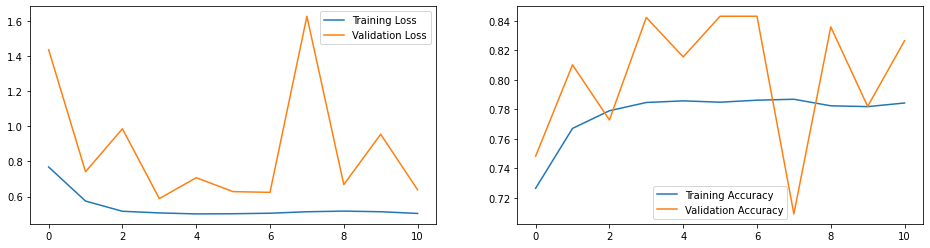

In [50]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [52]:
#confusion matrix generation

pred10_val= model_10.predict(x_valid_split)
pred10_val=np.argmax(pred10_val, axis=1)

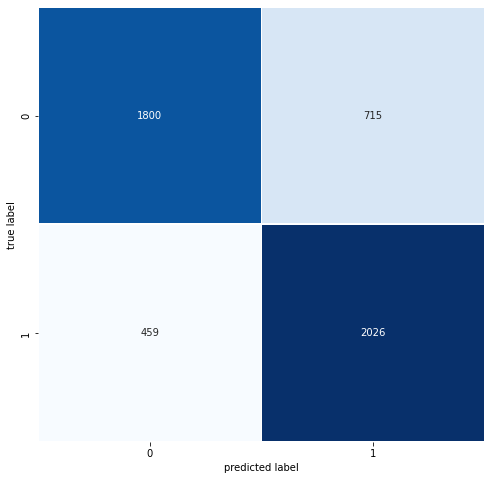

In [53]:
plot_confusion_matrix(y_valid_split,pred10_val)

#Model 11. VGG16



*   Image Data Preparation - will use the data from Model 10
*   VGG16 Image Embeddings Backfill
*   Training Multi-layer Perceptron Classifier.

In [44]:

from keras.applications.vgg16 import VGG16


In [42]:
train_img_names = os.listdir(train_dir)
train_labels = []

for file in train_img_names:
    train_labels.append(file.split(".")[0])

df_train = pd.DataFrame({"id": train_img_names, "label": train_labels})

In [43]:
df_train.head()

,id,label
0,cat.10613.jpg,cat
1,cat.7065.jpg,cat
2,dog.4677.jpg,dog
3,cat.2305.jpg,cat
4,cat.11144.jpg,cat


In [45]:
train_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0.20)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            train_dir,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(64, 64),
            batch_size=64,
            subset='training',
            class_mode='binary')

train_labels = to_categorical(train_generator.classes)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 20000 validated image filenames belonging to 2 classes.


In [46]:
valid_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            train_dir,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=False,
            target_size=(64, 64),
            batch_size=64,
            subset='validation',
            class_mode='binary')

Found 5000 validated image filenames belonging to 2 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [47]:
test_files = os.listdir(test_dir)
df_test = pd.DataFrame({"id": test_files, 'label': 'nan'})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)    
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        test_dir, 
        x_col='id',
        y_col=None, 
        has_ext=True, 
        target_size=(64, 64), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )

Found 12500 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [49]:
model_11 = Sequential()
model_11.add(VGG16(include_top=False, weights="imagenet", input_tensor=None,
            input_shape=(64, 64, 3)))
model_11.add(layers.Flatten())
model_11.add(layers.Dropout(0.5))
model_11.add(layers.Dense(units=128, activation=tf.nn.relu))
model_11.add(layers.Dropout(0.3))
model_11.add(layers.Dense(units=64, activation=tf.nn.relu))
model_11.add(Dense(2, activation = 'softmax'))


In [50]:
model_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                

In [51]:
model_11.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [52]:
start_time = time.time()

history_11 = model_11.fit_generator(
                     generator = train_generator
                    ,validation_data = valid_generator
                    ,epochs=30
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Epoch 1/30
313/313 [==============================] - 1971s 6s/step - batch: 156.0000 - size: 63.8978 - loss: nan - acc: 0.5006 - val_loss: nan - val_acc: 0.4976
Epoch 2/30
 78/313 [======>.......................] - ETA: 23:13 - batch: 38.5000 - size: 64.0000 - loss: nan - acc: 0.5060

KeyboardInterrupt: ignored

In [ ]:
train_time = end_time - start_time

In [ ]:
model_11_score = score_track(model_11, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_11_score

{'accuracy_train': 0.92045,
 'accuracy_valid': 0.849,
 'f1_val': 0.8484580800325194,
 'precision_val': 0.8549766849974412,
 'recall_val': 0.8493893780176086}

In [ ]:
model_11_score['train_time'] = train_time

In [ ]:
preds_11 = model_9.predict(X_test)
print('shape of preds: ', preds_9.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_9.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
12,0.335,0.877,0.548,0.806
13,0.335,0.881,0.463,0.840
14,0.343,0.889,0.462,0.849
15,0.318,0.897,0.404,0.856
16,0.317,0.900,0.449,0.849


In [ ]:
losses = history_11.history['loss']
accs = history_11.history['acc']
val_losses = history_11.history['val_loss']
val_accs = history_11.history['val_acc']
epochs = len(losses)

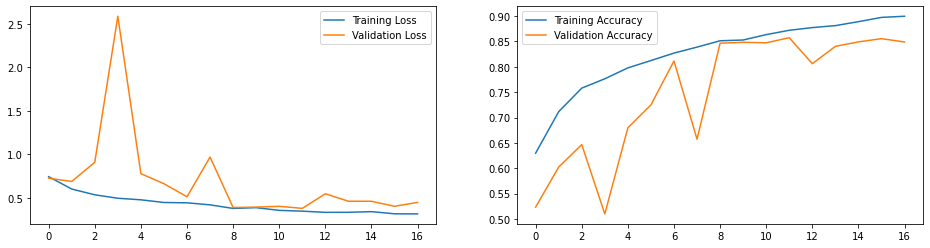

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred11_val= model_11.predict(x_valid_split)
pred11_val=np.argmax(pred11_val, axis=1)

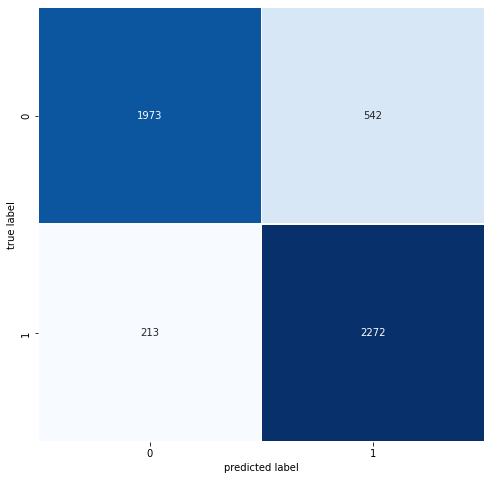

In [ ]:
plot_confusion_matrix(y_valid_split,pred11_val)

In [53]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/458_AI/A4/Assignment4_Part2_CNNResNetVGG.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/458_AI/A4/Assignment4_Part2_CNNResNetVGG.ipynb to html
[NbConvertApp] Writing 1763570 bytes to /content/gdrive/MyDrive/458_AI/A4/Assignment4_Part2_CNNResNetVGG.html
